# Problem 6 - Phase Identification(2)

## Agenda
- Problem Description
- Problem Implementation
- Wrap-Up

## Problem Description
- <b>Consider $N$ customers whose connection phase assumes one out of three possible labels $a$, $b$, or $c$ and estimate the correct customer-to-label assignment based on $M$ readings whose per-phase values are a function of the corresponding phase-connected individual customer reading.

Considered network
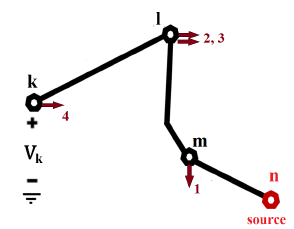

<b>Import Python Libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Parameters

In [60]:
cosPhi=0.95
time=48
m=12
netFactor=0.25
noiseFactor=0.00

<b>Initial data

In [61]:
#Consumption dataset
s=  [[0.0450,    0.0150,    0.0470,    0.0330],
     [0.0250,    0.0150,    0.2480,    0.0330],
     [0.0970,    0.0250,    0.3940,    0.0330],
     [0.0700,    0.0490,    0.0200,    0.4850],
     [0.1250,    0.0460,    0.0160,    0.1430],
     [0.2900,    0.0270,    0.0160,    0.0470],
     [0.2590,    0.0150,    0.0170,    0.0200],
     [0.2590,    0.0160,    0.0280,    0.0160],
     [0.4420,    0.0160,    0.0500,    0.0170],
     [0.2010,    0.0230,    0.0460,    0.0160],
     [0.2060,    0.0490,    0.0220,    0.0240],
     [0.1300,    0.0470,    0.0160,    0.0490],
     [0.0460,    0.0260,    0.0170,    0.0480]]
s = np.array(s)

#topology
topo=[[1, 2],[2,3],[3,4]]
nBUS=np.max(topo)

#Impedance
# z = [z_nm, z_ml, z_lk]
z=np.multiply([complex(0.1,0.05),complex(0.15,0.07),complex(0.2,0.1)],netFactor)

vr=1 #Reference voltage
el=1
ni=20 #Iterations for the Power Flow




<b>Power Flow Function

In [62]:
def pf3ph(t,z,si,vr,el,ni,al):
    #Matrices creation
    t=np.array(t)
    p=t[:,0]
    f=t[:,1]
    w=len(p)+1
    vp=np.zeros((nBUS-1,w), dtype=complex)
    vn=np.zeros((nBUS-1,w), dtype=complex)
    vp[0,0:w]=vr
    
    for h in range (2,nBUS):
        vp[h-1,:]=vp[h-2,:]*al  #Create a three phase system of voltages
                                #Voltages will be the same in all BUS

    va=vp-vn                                                      #Auxiliar voltage
    ia=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))      #Auxiliar current 
    
    for it in range(ni):                                          #Iterations of Power Flow
        va=vp-vn
        ip=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))  #Phase current 
        inn=-np.sum(ip,0)                                         #Neutral current 
        for k in range(w-1,0,-1):                                 #Backward Cycle
            n=f[k-1]
            m=p[k-1]
            ip[:,m-1]=ip[:,m-1]+ip[:,n-1]                         #Phase Current
            inn=-np.sum(ip,0)                                     #Neutral Current

        eps= np.linalg.norm(np.max(np.abs(ia-ip),0))              #Error, comparing the new currents and the old ones (previous iteration)

        if eps>1e-4:
            ia=ip
            mvp=0
            mvn=0
            eps=np.inf
        else:                       #If the error is lower than the limit, we can return the results 
            mvp=(vp-vn)             #Phase Voltages to return
            mvn=vn[0,:]             #Neutral Voltage to return
#            return mvp, mvn, eps, ip, inn;
            return mvp;
        for k in range (w-1):                     #Forward Cycle
            n=f[k]                                
            m=p[k]
            vn[:,n-1]=vn[:,m-1]-z[k]*inn[n-1]     #Neutral Voltage 
            vp[:,n-1]=vp[:,m-1]-z[k]*ip[:,n-1]    #Phase Voltage
        ia=ip             #Save the current of previous iteration


<b> Compute the values of voltages obtained by PMUs

In [63]:
#Creation of Matrices
al=np.exp(np.multiply(np.multiply(complex(0,-1),2/3),np.pi)) #Phase Angle
Y=np.zeros((3*m), dtype=complex)
X=np.zeros((3*m,m), dtype=complex)
v=np.zeros((m,3))
dv_abs=np.zeros((m,3))


for i in range(m):
    si=[[0, 0, s[i,2], 0],[0, 0, s[i,1], 0],[0, s[i,0],  0, s[i,3]]] #Connection of consumers by
                                                                     #node and by phase
                                                                     #Consumer 1 (s[i,0]) is 
                                                                     #connected to Bus 2 in Phase 3
    mvp=pf3ph(topo,z,si,vr,el,ni,al)
    noise=1+noiseFactor*np.random.randn(3)
    mvp[:,3]=np.multiply(mvp[:,3],noise)                       #Add noise to the voltages
    Y[3*(i):3*(i)+3]=mvp[:,3]                                  #Save the voltages in matrix Y
    dv_abs[i,:]=vr-np.abs(mvp[:,3])                            #Voltage variations (only to plot)

Volt=np.reshape(Y,(m,3))   

print ('The voltages measured in the PMUs are:\n',Volt)


The voltages measured in the PMUs are:
 [[ 0.99866484-0.00476962j -0.49831414-0.86835917j -0.49392011+0.85964588j]
 [ 0.97290228-0.01601085j -0.51139766-0.87380016j -0.50744349+0.85456696j]
 [ 0.95608633-0.02441701j -0.51885398-0.87750207j -0.51325967+0.84910673j]
 [ 1.04767033-0.03551787j -0.45091668-0.89757332j -0.40102796+0.79332501j]
 [ 1.01576499-0.00999985j -0.48302166-0.87236861j -0.46567302+0.84426734j]
 [ 1.00968654-0.00695356j -0.48918564-0.87063669j -0.47774451+0.85167455j]
 [ 1.00602188-0.005418j   -0.49284148-0.869901j   -0.48483326+0.85566688j]
 [ 1.00423842-0.00571336j -0.4939299 -0.86980129j -0.48633757+0.85598497j]
 [ 1.00578779-0.00995392j -0.4910006 -0.87340185j -0.4790803 +0.84942259j]
 [ 1.0006834 -0.00538471j -0.49631931-0.86845387j -0.49010362+0.8577634j ]
 [ 1.00475844-0.00282624j -0.4936193 -0.86480633j -0.48660002+0.8589564j ]
 [ 1.00631448-0.00319825j -0.49244873-0.86549546j -0.48460471+0.85781421j]]


<b> Sum of Impedences
    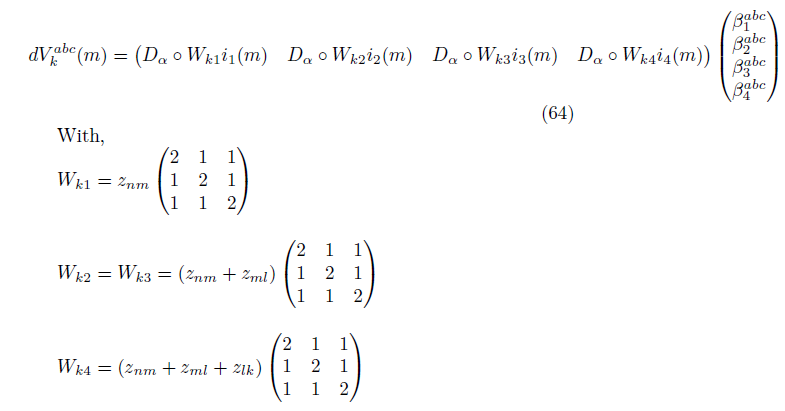

In [64]:
#The value of Z is the multiplication between D and W but not considering the values of z_nm;z_ml and z_lk
Z=[[2, al, al**2],[1, 2*al, al**2],[1, al, 2*al**2]]
Z=np.array(Z)

<b>Complex Expansion
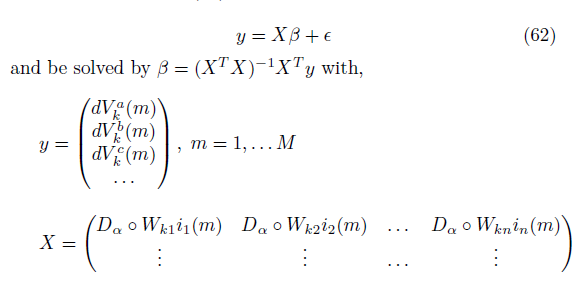

In [65]:

vz=np.zeros(3*m, dtype=complex)
vz_abs=np.zeros(3*m, dtype=complex)

#Compute dVk for each time period m   
#dvk is the yk vector in the paper (Please use the value Y)
for i in range (m):
    vz[3*(i):3*(i)+3]= np.multiply(vr,[1, al, al**2] ) -  Y[3*(i):3*(i)+3]    #With PMUs info
    vz_abs[3*(i):3*(i)+3]=np.multiply(vr-np.absolute(Y[3*(i):3*(i)+3]),[1, al, al**2])   #With RTUs info


# Compute X matrix considering different W (Please use the value Z)


X=np.zeros((3*m,m), dtype=complex)
for i in range(m):
    X[3 * i: 3 * i + 3, :3] = Z * s[i, 0]
    X[3 * i: 3 * i + 3, 3:6] = Z * s[i, 1]
    X[3 * i: 3 * i + 3, 6:9] = Z * s[i, 2]
    X[3 * i: 3 * i + 3, 9:12] = Z * s[i, 3]
    
# finally multiplying by z_nm, z_ml and z_lk
X[:,0:3]*=z[0]
X[:,3:6]*=z[0]+z[1]
X[:,6:9]*=z[0]+z[1]
X[:,9:12]*=z[0]+z[1]+z[2]




TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
import matplotlib.ticker as ticker


def barplot_betas(betas, title, log):
    # create a dataframe with the betas
    df = pd.DataFrame(betas.reshape(-1,3), columns=["A", "B", "C"])
    # create a barplot
    ax = df.plot.bar(rot=0, figsize=(10,5), title=title)
    # set the xticks to the consumer number
    ax.set_xticklabels([i+1 for i in range(len(df))])
    # set the y label to the betas
    ax.set_ylabel("Beta")
    # set the x label to the consumer number
    ax.set_xlabel("Consumer")
    # if log=True, set the y scale to symlog with a minimum value of the minimum beta
    if log:
        min_beta = df.min().min()
        ax.set_yscale("symlog", linthresh=0.00001, linscale=0.5)
        ax.set_ylim([min_beta, None])
        # set the y-axis ticks formatter
        def format_y_axis(x, pos):
            if x == 1:
                return "1.00"
            elif x == -1:
                return "-1.00"
            elif x == 0:
                return "0.00"
            else:
                return f"{x:.0e}"
        ax.yaxis.set_major_formatter(format_y_axis)
    # show the plot
    plt.show()


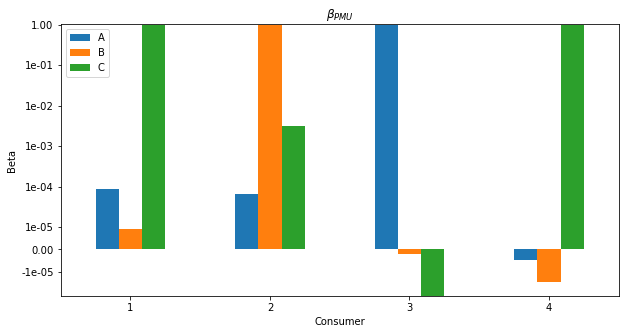

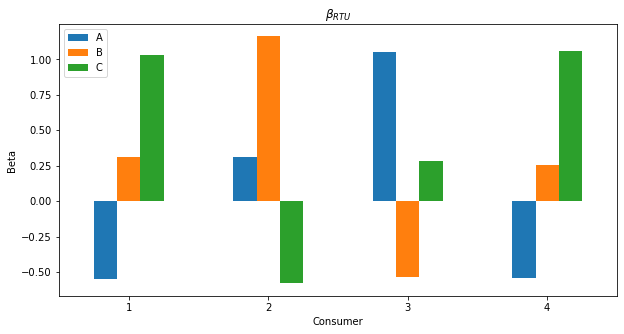

The phases of the consumers are:
PMU:  ['c', 'b', 'a', 'c']
RTU:  ['c', 'b', 'a', 'c']


In [ ]:
def numb_to_letter(num):
    return chr(num + 96)

# summing up the beta computation process in a function
def compute_betas(X, vz):
    # compute the betas
    B = np.linalg.inv(X.T @ X) @ X.T @ vz
    # take the real part of the betas
    B_real = np.real(B)
    return B_real

# summing up the phase extraction from the betas in a function
def extract_phases(B_real):
    # find the phase of each consumer
    list_phases = []
    for i in range(len(B_real)//3):
        # person_phase will be the index of the closeset value to 1 out of the three phases, from 1 to 3
        person_phase = np.argmin(np.abs(B_real[3*i:3*i+3]-1)) + 1
        # convert the index to the letter of the phase
        phase = numb_to_letter(person_phase)
        # append the phase to the list
        list_phases.append(phase)
    return list_phases


def summarize_phase_id(X,vz,vz_abs):
    Bpmu_real = compute_betas(X, vz)
    Brtu_real = compute_betas(X, vz_abs)
    list_phases_pmu = extract_phases(Bpmu_real)
    list_phases_rtu= extract_phases(Brtu_real)
    # barplot the betas
    barplot_betas(Bpmu_real, r"$\beta_{PMU}$", True)
    barplot_betas(Brtu_real, r"$\beta_{RTU}$", False)
    # print the phases as lists
    print("The phases of the consumers are:")
    print("PMU: ",list_phases_pmu)
    print("RTU: ",list_phases_rtu)

# shapes of vz, X, beta
# (36,) (36, 12) (12,)
    

summarize_phase_id(X,vz,vz_abs)

<b>Graphics

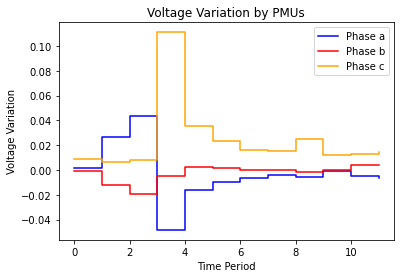

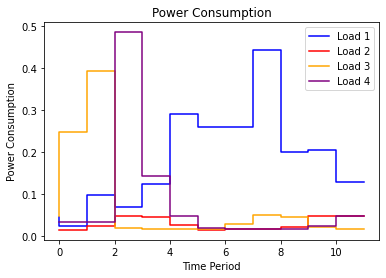

In [ ]:
import matplotlib.pyplot as plt

# Specify the data to plot
x = np.arange(m)
y1 = dv_abs
y2 = s[0:12,:]


# Graph 1
plt.figure()
plt.title("Voltage Variation by PMUs")
plt.step(x, y1[:, 0], color='blue', where='post', label='Phase a')
plt.step(x, y1[:, 1], color='red',where='post', label='Phase b')
plt.step(x, y1[:, 2], color='orange', where='post',label='Phase c')
plt.xlabel("Time Period")
plt.ylabel("Voltage Variation")
plt.legend()
plt.show()

# Graph 2
plt.figure()
plt.title("Power Consumption")
plt.step(x, y2[:, 0], color='blue', label='Load 1')
plt.step(x, y2[:, 1], color='red', label='Load 2')
plt.step(x, y2[:, 2], color='orange', label='Load 3')
plt.step(x, y2[:, 3], color='purple', label='Load 4')
plt.xlabel("Time Period")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

# Show the plots
plt.show()

In [ ]:
"""
import numpy as np

def add_intermittent_loads(X, p_intermittent=0.2, scale_factor=0.5):
    X_intermittent = X.copy()
    num_customers, num_periods = X.shape
    num_intermittent = int(p_intermittent * num_customers)
    
    for i in range(num_intermittent):
        customer_idx = np.random.randint(num_customers)
        time_idx = np.random.randint(num_periods)
        X_intermittent[customer_idx, time_idx] += scale_factor * X[customer_idx, time_idx]
    
    return X_intermittent

X_intermittent = add_intermittent_loads(X)

# Now, use X_intermittent in the phase identification process and compare the results with the original X.

"""

'\nimport numpy as np\n\ndef add_intermittent_loads(X, p_intermittent=0.2, scale_factor=0.5):\n    X_intermittent = X.copy()\n    num_customers, num_periods = X.shape\n    num_intermittent = int(p_intermittent * num_customers)\n    \n    for i in range(num_intermittent):\n        customer_idx = np.random.randint(num_customers)\n        time_idx = np.random.randint(num_periods)\n        X_intermittent[customer_idx, time_idx] += scale_factor * X[customer_idx, time_idx]\n    \n    return X_intermittent\n\nX_intermittent = add_intermittent_loads(X)\n\n# Now, use X_intermittent in the phase identification process and compare the results with the original X.\n\n'

# Extra Challenges

## $\cdot$ Intermittent loads:
The idea behind this extra Challenge is to introduce intermittent loads to the dataset, simulating real-world scenarios where the consumption pattern is not constant. In a practical smart grid, customers may have varying energy consumption levels throughout the day due to various factors such as appliance usage, weather conditions, or personal habits. By incorporating these intermittent loads into the dataset, we can examine how well the phase identification algorithm performs under more realistic conditions.

X changed with the intermittent loads? R: False


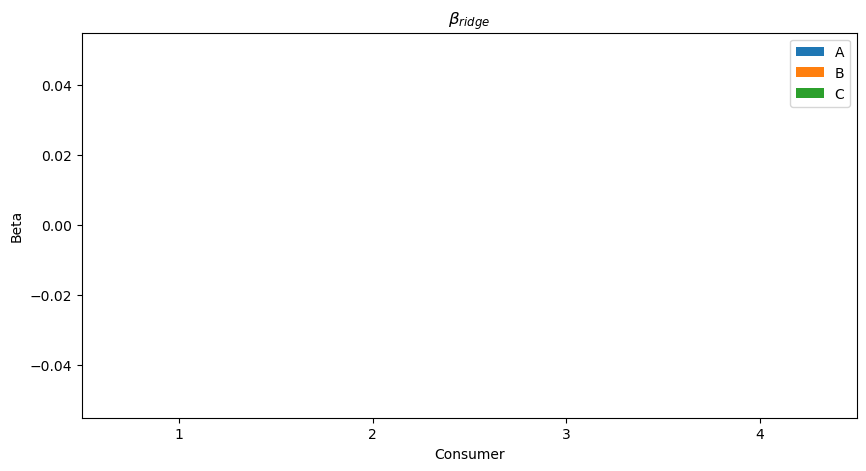

['a', 'a', 'a', 'a']

In [66]:

def add_intermittent_loads(X, p_intermittent, scale_factor):
    X_intermittent = X.copy()
    num_customers, num_periods = X.shape
    num_intermittent = int(p_intermittent * num_customers)
    
    for i in range(num_intermittent):
        customer_idx = np.random.randint(num_customers)
        time_idx = np.random.randint(num_periods)
        X_intermittent[customer_idx, time_idx] += scale_factor * X[customer_idx, time_idx]
    
    return X_intermittent

X_intermittent = add_intermittent_loads(X,p_intermittent=0.1, scale_factor=2)

print("X changed with the intermittent loads? R:", np.any(X_intermittent != X))

# Now, use X_intermittent in the phase identification process and compare the results with the original X.
#summarize_phase_id(X_intermittent,vz,vz_abs)

# solve using ridge regression
def compute_betas_ridge(X, vz, alpha):
    B = np.linalg.inv(X.T @ X + alpha * np.identity(X.shape[1])) @ X.T @ vz
    B_real = np.real(B)
    return B_real

# getting phases and barplot
betas_ridge = compute_betas_ridge(X, vz, 0.01)
barplot_betas(betas_ridge, r"$\beta_{ridge}$", False)
extract_phases(betas_ridge)




## $\cdot$ Clustering (KMeans)

In [ ]:
from sklearn.cluster import KMeans

def cluster_phase_identification(X, vz, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    
    phase_labels = np.empty(X.shape[0], dtype=np.int32)
    for i, label in enumerate(cluster_labels):
        phase_labels[i] = np.argmax(vz[:, label])
    
    return phase_labels

#phase_labels = cluster_phase_identification(X, vz)
